In [1]:
import numpy as np
import os, sys

from osgeo import gdal
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt

In [2]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [107]:
raster_data_path = "images/tiles/tile_1000_4000.tif"
output_fname = ".classification.tif"
shapefile_path = "./shape_files/splits/"
# validation_data_path = "data/train/"

In [108]:
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []

In [109]:
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

In [110]:
print(rows, cols, n_bands)

1000 1000 11


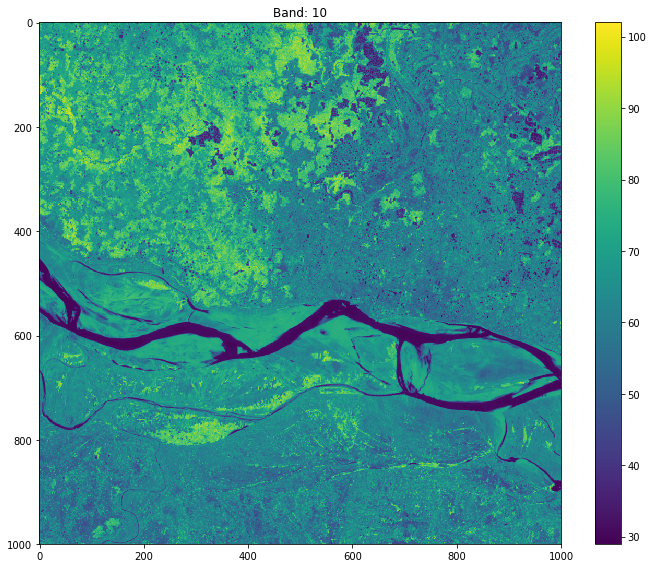

In [111]:
plt.figure(figsize=(10, 8))
plt.imshow(bands_data[:, :, 6])
plt.title('Band: {}'.format(10))
plt.colorbar()
plt.tight_layout()
plt.show()

In [112]:
files = [f for f in os.listdir(shapefile_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
shapefiles = [os.path.join(shapefile_path, f)
              for f in files if f.endswith('.shp')]

In [113]:
data_source = gdal.OpenEx(shapefile_path, gdal.OF_VECTOR)
layer = data_source.GetLayer(0)

In [114]:
labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform, proj)

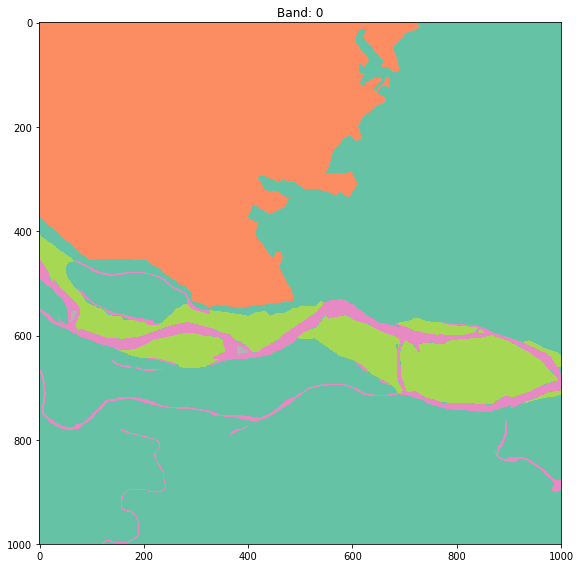

In [115]:
plt.figure(figsize=(10, 8))
plt.imshow(labeled_pixels.astype(np.float64), cmap = 'Set2')
plt.title('Band: {}'.format(0))
plt.tight_layout()
plt.show()

In [116]:
is_train = np.nonzero(labeled_pixels)

In [117]:
print(np.shape(labeled_pixels), np.shape(bands_data))

(1000, 1000) (1000, 1000, 11)


In [118]:
xtrain = np.delete(bands_data, 10, 2)

In [119]:
xtrain = np.delete(xtrain, 9, 2)

In [120]:
n_samples = rows*cols
flat_pixels = xtrain.reshape((n_samples, 9))

In [122]:
print(np.shape(training_labels))

(1000, 1000)


In [123]:
ytrain = labeled_pixels.reshape((n_samples, 1))

In [201]:
from scipy.stats import itemfreq

print(itemfreq(ytrain).astype(int))

[[     0 614037]
 [     1 274063]
 [     2  35328]
 [     3  76151]
 [     5    421]]


### Scaling 

In [125]:
from sklearn.preprocessing import StandardScaler
mms = StandardScaler()
xtrain_scaled = mms.fit_transform(flat_pixels)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [126]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(xtrain_scaled, ytrain)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [127]:
result = classifier.predict(xtrain_scaled)

In [128]:
print(np.shape(result))

(1000000,)


In [130]:
classification = result.reshape((rows, cols))

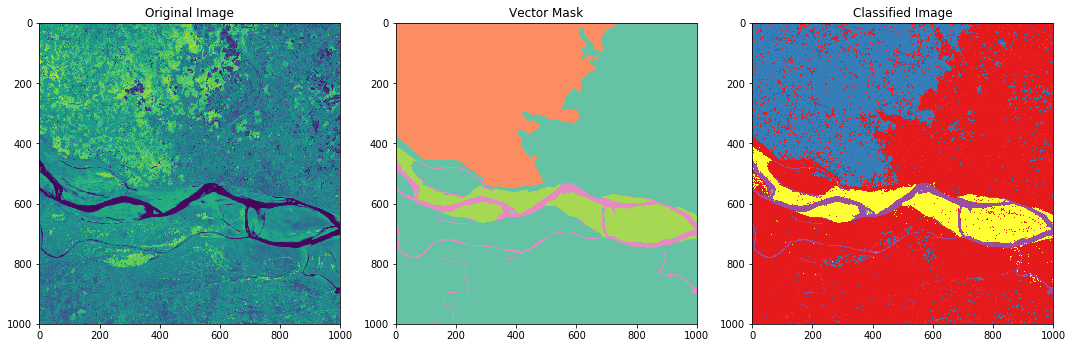

In [133]:
f = plt.figure(figsize=(15, 10))

plt.subplot(1, 3, 1)
plt.imshow(bands_data[:, :, 6])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(labeled_pixels.astype(np.float64), cmap = 'Set2')
plt.title('Vector Mask')

plt.subplot(1, 3, 3)
plt.imshow(classification, cmap='Set1')
plt.title('Classified Image')
plt.tight_layout()
plt.show()

###  Testing

In [156]:
test_data_path = "images/tiles/tile_5000_5000.tif"
test_raster = gdal.Open(test_data_path, gdal.GA_ReadOnly)
geo_transform = test_raster.GetGeoTransform()
proj = test_raster.GetProjectionRef()
test_bands_data = []

In [157]:
for b in range(1, test_raster.RasterCount+1):
    band = test_raster.GetRasterBand(b)
    test_bands_data.append(band.ReadAsArray())

test_bands_data = np.dstack(test_bands_data)
test_rows, test_cols, test_n_bands = test_bands_data.shape

In [158]:
np.shape(test_bands_data)

(1000, 1000, 11)

In [159]:
xtest = np.delete(test_bands_data, 10, 2)
xtest = np.delete(xtest, 9, 2)

In [160]:
np.shape(xtest)

(1000, 1000, 9)

In [161]:
test_flat_pixels = xtest.reshape((n_samples, 9))
test_mms = StandardScaler()
xtest_scaled = test_mms.fit_transform(test_flat_pixels)

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [164]:
test_result = classifier.predict(xtest_scaled)
test_classification = test_result.reshape((rows, cols))

In [206]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [207]:
discrete_cmap(5, 'rainbow')

rainbow5


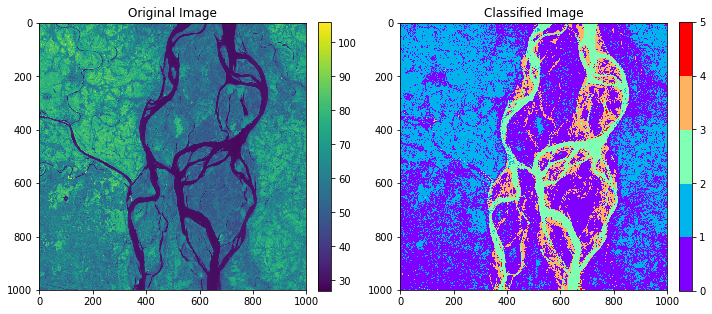

In [202]:
f = plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
im = plt.imshow(test_bands_data[:, :, 6])
plt.title('Original Image')
plt.colorbar(im,fraction=0.046, pad=0.04)

plt.subplot(1, 2, 2)
im = plt.imshow(test_classification, cmap=discrete_cmap(5, 'rainbow'))
plt.title('Classified Image')
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [57]:
write_geotiff(output_fname, classification, geo_transform, proj)